In [63]:
import pickle
import pandas as pd
import xgboost as xgb
import numpy as np

from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras

import seaborn as sns
import matplotlib.pylab as plt

## Model Comparison

This notebook serves to run a comparison of various models on the existing Proboscidia and Felid datasets in order to determine the most promising model, to be used. 

Models to be compared include: 
- Decision Tree
- Random Forest
- XG Boost
- AdaBoost
- Neural Network

Please note that the data transformation pipelines, make use of oversampling in order to reduce the dataset imbalance. And where available the below models will weight the classes during training.

Initialize overall classification report collection dataframe

In [2]:
report_collection_df = pd.DataFrame()
accuracy_collection_df = pd.DataFrame()

### Pre-required Methods

In [124]:
# Method to add classification report into a dataframe structure
def add_model_report(report_collection_df: pd.DataFrame, y_val, y_pred, taxon_level:str, model: str):
    classes = y_val.nunique()
    report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
    
    report_df = pd.DataFrame(report).transpose()
    report_df['taxon_level'] = taxon_level
    report_df['model_type'] = model
    report_df = report_df.head(classes)
    
    return pd.concat([report_collection_df, report_df], sort=False)


def add_model_accuracy(accuracy_collection_df: pd.DataFrame, y_val, y_pred, taxon_level: str, model: str):
    accuracy = balanced_accuracy_score(y_val, y_pred)  
    
    accuracy_df = pd.DataFrame()
    accuracy_df['accuracy'] = [accuracy]
    accuracy_df['taxon_level'] = [taxon_level]
    accuracy_df['model_type'] = [model]
    return pd.concat([accuracy_collection_df, accuracy_df], sort=False)


# Prep the validation set for Decision tree like models (dt)
def prep_dt_validationSet(df:pd.DataFrame, taxon_target:str):
    taxon_y = df[taxon_target]
    
    if taxon_y.isnull().any():
        df = df.dropna(subset=[taxon_target])
    
    y = df[taxon_target]
    X = df.drop(columns=['taxon_kingdom_name', 'taxon_phylum_name',
                             'taxon_class_name', 'taxon_order_name', 'taxon_family_name',
                             'taxon_genus_name', 'taxon_species_name', 'sub_species', 'common_name'])

    return X, y


# Prep the validation set for Xgboost models (dt)
def prep_xgb_validationSet(df:pd.DataFrame, taxon_target:str):
    taxon_y = df[taxon_target]
    
    if taxon_y.isnull().any():
        df = df.dropna(subset=[taxon_target])
    
    y = df[taxon_target]
    X = df.drop(columns=['taxon_kingdom_name', 'taxon_phylum_name',
                             'taxon_class_name', 'taxon_order_name', 'taxon_family_name',
                             'taxon_genus_name', 'taxon_species_name', 'sub_species', 'common_name'])
    classes = y.nunique()
    
    # Encode labels
    classes = y.nunique()
    lb = LabelBinarizer()
    lb.fit(y)
    y = lb.transform(y)
    
    if classes == 2:
        y = nn_binary_label_handling(y)
    
    return X, y, lb


# If a single label is produced, enforces a double binary format
def nn_binary_label_handling(y):
    return np.hstack((1 - y.reshape(-1, 1), y.reshape(-1, 1)))


# Convert ohe y-values into correct taxon labels
def convert_to_labels(y_val, y_pred, lb):
    ohe_length = len(y_val[0])
    y_pred_ohe = np.zeros(shape=(len(y_val), ohe_length))
    
    y_val = pd.Series(lb.inverse_transform(y_val))
    y_pred_indices = np.argmax(y_pred, axis=1)
    
    for i in range(len(y_val)):
        y_pred_ohe[i, y_pred_indices[i]] = 1
    y_pred = lb.inverse_transform(y_pred_ohe)
    return y_val, y_pred


# Prep the validation set for Neural network models (dt)
def prep_nn_validationSet(df:pd.DataFrame, taxon_target:str):
    taxon_y = df[taxon_target]
    
    if taxon_y.isnull().any():
        df = df.dropna(subset=[taxon_target])
    
    y = df[taxon_target]
    X = df.drop(columns=['taxon_kingdom_name', 'taxon_phylum_name',
                             'taxon_class_name', 'taxon_order_name', 'taxon_family_name',
                             'taxon_genus_name', 'taxon_species_name', 'sub_species', 'common_name'])
    
    classes = y.nunique()
    
    # Encode labels
    classes = y.nunique()
    lb = LabelBinarizer()
    lb.fit(y)
    y = lb.transform(y)
    
    if classes == 2:
        y = nn_binary_label_handling(y)
    
    
    # Normalize numerical columns in the dataset
    norm_columns = ['apparent_temperature', 'apparent_temperature_max', 'apparent_temperature_min',
                    'cloudcover', 'cloudcover_high', 'cloudcover_low', 'cloudcover_mid', 'dewpoint_2m',
                    'diffuse_radiation', 'direct_radiation', 'elevation', 'et0_fao_evapotranspiration_daily',
                    'et0_fao_evapotranspiration_hourly', 'precipitation', 'precipitation_hours',
                    'precipitation_sum', 'rain', 'rain_sum', 'relativehumidity_2m', 'shortwave_radiation',
                    'shortwave_radiation_sum', 'snowfall', 'snowfall_sum', 'soil_moisture_0_to_7cm',
                    'soil_moisture_28_to_100cm', 'soil_moisture_7_to_28cm', 'soil_temperature_0_to_7cm',
                    'soil_temperature_28_to_100cm', 'soil_temperature_7_to_28cm', 'surface_pressure',
                    'temperature_2m', 'temperature_2m_max', 'temperature_2m_min', 'vapor_pressure_deficit',
                    'winddirection_100m', 'winddirection_10m', 'winddirection_10m_dominant',
                    'windgusts_10m', 'windgusts_10m_max', 'windspeed_100m', 'windspeed_10m',
                    'windspeed_10m_max']

    X[norm_columns] = StandardScaler().fit_transform(X[norm_columns])
    return X, y, lb

## Proboscidia Dataset

### Decision Tree

#### Genus Taxonomy

Load the model

In [72]:
dt_proboscidia_genus_model = pickle.load(open('model_comparison_cache_2/elephantidae_dt_model.sav', 'rb'))

Import the evaluation Dataset.

In [73]:
dt_genus_df_val = pd.read_csv('model_comparison_cache_2/elephantidae_dt_validation.csv', index_col=0)

Generate True labels and predicted labels

In [74]:
X_val, y_val = prep_dt_validationSet(dt_genus_df_val, 'taxon_genus_name')
y_pred = dt_proboscidia_genus_model.predict(X_val)

/home/travisdawson/anaconda3/envs/spatiotemp_class_env/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Classification report

In [75]:
proboscidia_genus_df_report = classification_report(y_val, y_pred)
print(proboscidia_genus_df_report)

              precision    recall  f1-score   support

     Elephas       0.97      0.98      0.98       317
   Loxodonta       1.00      0.99      1.00      1480

    accuracy                           0.99      1797
   macro avg       0.99      0.99      0.99      1797
weighted avg       0.99      0.99      0.99      1797



Save classification report for model comparison

In [76]:
report_collection_df = add_model_report(report_collection_df, y_val, y_pred, 'Genus', 'Decision tree')

In [77]:
report_collection_df

,precision,recall,f1-score,support,taxon_level,model_type
Elephas,0.974922,0.981073,0.977987,317.0,Genus,Decision tree
Loxodonta,0.995940,0.994595,0.995267,1480.0,Genus,Decision tree


In [87]:
accuracy_report  = add_model_accuracy(accuracy_collection_df, y_val, y_pred, 'Genus', 'Decision tree')

0.9922092376182526
   accuracy taxon_level     model_type
0  0.992209       Genus  Decision tree


In [88]:
accuracy_report.head()

,accuracy,taxon_level,model_type
0,0.992209,Genus,Decision tree


#### Species Taxonomy

Note, Elephas Genus only contains a single species, such that model would not be required, due to the single species possibility.

##### Loxodonta

In [61]:
dt_loxodonta_species_model = pickle.load(open('model_comparison_cache_2/loxodonta_dt_model.sav', 'rb'))

In [62]:
dt_species_df_val = pd.read_csv('model_comparison_cache_2/loxodonta_dt_validation.csv', index_col=0)

In [63]:
X_val, y_val = prep_dt_validationSet(dt_species_df_val, 'taxon_species_name')
y_pred = dt_loxodonta_species_model.predict(X_val)

/home/travisdawson/anaconda3/envs/spatiotemp_class_env/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [64]:
loxodonta_species_dt_report = classification_report(y_val, y_pred)
print(loxodonta_species_dt_report)

                    precision    recall  f1-score   support

Loxodonta africana       1.00      1.00      1.00      1442
Loxodonta cyclotis       0.89      0.84      0.86        38

          accuracy                           0.99      1480
         macro avg       0.94      0.92      0.93      1480
      weighted avg       0.99      0.99      0.99      1480



In [65]:
report_collection_df = add_model_report(report_collection_df, y_val, y_pred, 'Species', 'Decision tree')

In [66]:
report_collection_df.head()

,precision,recall,f1-score,support,taxon_level,model_type
Elephas,0.974922,0.981073,0.977987,317.0,Genus,Decision tree
Loxodonta,0.995940,0.994595,0.995267,1480.0,Genus,Decision tree
Loxodonta africana,0.995845,0.997226,0.996535,1442.0,Species,Decision tree
Loxodonta cyclotis,0.888889,0.842105,0.864865,38.0,Species,Decision tree


#### Elephas Sub-species

In [67]:
dt_elephas_subspecies_model = pickle.load(open('model_comparison_cache_2/elephas_maximus_dt_model.sav', 'rb'))

In [68]:
dt_subspecies_df_val = pd.read_csv('model_comparison_cache_2/elephas_maximus_dt_validation.csv', index_col=0)

In [69]:
X_val, y_val = prep_dt_validationSet(dt_subspecies_df_val, 'sub_species')
y_pred = dt_elephas_subspecies_model.predict(X_val)

/home/travisdawson/anaconda3/envs/spatiotemp_class_env/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [70]:
elephas_subspecies_report = classification_report(y_val, y_pred)
print(elephas_subspecies_report)

                            precision    recall  f1-score   support

Elephas maximus borneensis       1.00      1.00      1.00        30
   Elephas maximus indicus       0.99      1.00      1.00       149
   Elephas maximus maximus       1.00      1.00      1.00        94
Elephas maximus sumatranus       1.00      0.67      0.80         3

                  accuracy                           1.00       276
                 macro avg       1.00      0.92      0.95       276
              weighted avg       1.00      1.00      1.00       276



In [71]:
report_collection_df = add_model_report(report_collection_df, y_val, y_pred, 'Sub-species', 'Decision tree')

In [72]:
report_collection_df.head(10)

,precision,recall,f1-score,support,taxon_level,model_type
Elephas,0.974922,0.981073,0.977987,317.0,Genus,Decision tree
Loxodonta,0.995940,0.994595,0.995267,1480.0,Genus,Decision tree
Loxodonta africana,0.995845,0.997226,0.996535,1442.0,Species,Decision tree
Loxodonta cyclotis,0.888889,0.842105,0.864865,38.0,Species,Decision tree
Elephas maximus borneensis,1.000000,1.000000,1.000000,30.0,Sub-species,Decision tree
Elephas maximus indicus,0.993333,1.000000,0.996656,149.0,Sub-species,Decision tree
Elephas maximus maximus,1.000000,1.000000,1.000000,94.0,Sub-species,Decision tree
Elephas maximus sumatranus,1.000000,0.666667,0.800000,3.0,Sub-species,Decision tree


### Random Forest

#### Genus Taxonomy

In [73]:
rf_proboscidia_genus_model = pickle.load(open('model_comparison_cache_2/elephantidae_rf_model.sav', 'rb'))

In [74]:
rf_genus_df_val = pd.read_csv('model_comparison_cache_2/elephantidae_rf_validation.csv', index_col=0)

In [75]:
X_val, y_val = prep_dt_validationSet(rf_genus_df_val, 'taxon_genus_name')
y_pred = rf_proboscidia_genus_model.predict(X_val)

In [76]:
proboscidia_genus_rf_report = classification_report(y_val, y_pred)
print(proboscidia_genus_rf_report)

              precision    recall  f1-score   support

     Elephas       0.99      0.99      0.99       317
   Loxodonta       1.00      1.00      1.00      1480

    accuracy                           1.00      1797
   macro avg       1.00      1.00      1.00      1797
weighted avg       1.00      1.00      1.00      1797



In [77]:
report_collection_df = add_model_report(report_collection_df, y_val, y_pred, 'Genus', 'Random forest')

In [78]:
report_collection_df.head(15)

,precision,recall,f1-score,support,taxon_level,model_type
Elephas,0.974922,0.981073,0.977987,317.0,Genus,Decision tree
Loxodonta,0.995940,0.994595,0.995267,1480.0,Genus,Decision tree
Loxodonta africana,0.995845,0.997226,0.996535,1442.0,Species,Decision tree
Loxodonta cyclotis,0.888889,0.842105,0.864865,38.0,Species,Decision tree
Elephas maximus borneensis,1.000000,1.000000,1.000000,30.0,Sub-species,Decision tree
Elephas maximus indicus,0.993333,1.000000,0.996656,149.0,Sub-species,Decision tree
Elephas maximus maximus,1.000000,1.000000,1.000000,94.0,Sub-species,Decision tree
Elephas maximus sumatranus,1.000000,0.666667,0.800000,3.0,Sub-species,Decision tree
Elephas,0.993691,0.993691,0.993691,317.0,Genus,Random forest
Loxodonta,0.998649,0.998649,0.998649,1480.0,Genus,Random forest


#### Species Taxonomy

In [79]:
rf_loxodonta_species_model = pickle.load(open('model_comparison_cache_2/loxodonta_rf_model.sav', 'rb'))
rf_species_df_val = pd.read_csv('model_comparison_cache_2/loxodonta_rf_validation.csv', index_col=0)
X_val, y_val = prep_dt_validationSet(rf_species_df_val, 'taxon_species_name')
y_pred = rf_loxodonta_species_model.predict(X_val)

In [80]:
loxodonta_species_rf_report = classification_report(y_val, y_pred)
print(loxodonta_species_rf_report)

                    precision    recall  f1-score   support

Loxodonta africana       0.99      1.00      1.00      1442
Loxodonta cyclotis       1.00      0.79      0.88        38

          accuracy                           0.99      1480
         macro avg       1.00      0.89      0.94      1480
      weighted avg       0.99      0.99      0.99      1480



In [81]:
report_collection_df = add_model_report(report_collection_df, y_val, y_pred, 'Species', 'Random forest')

In [82]:
report_collection_df.tail()

,precision,recall,f1-score,support,taxon_level,model_type
Elephas maximus sumatranus,1.000000,0.666667,0.800000,3.0,Sub-species,Decision tree
Elephas,0.993691,0.993691,0.993691,317.0,Genus,Random forest
Loxodonta,0.998649,0.998649,0.998649,1480.0,Genus,Random forest
Loxodonta africana,0.994483,1.000000,0.997234,1442.0,Species,Random forest
Loxodonta cyclotis,1.000000,0.789474,0.882353,38.0,Species,Random forest


#### Sub-species Taxonomy

In [83]:
rf_elephas_subspecies_model = pickle.load(open('model_comparison_cache_2/elephas_maximus_rf_model.sav', 'rb'))
rf_subspecies_df_val = pd.read_csv('model_comparison_cache_2/elephas_maximus_rf_validation.csv', index_col=0)
X_val, y_val = prep_dt_validationSet(rf_subspecies_df_val, 'sub_species')
y_pred = rf_elephas_subspecies_model.predict(X_val)

In [84]:
elephas_subspecies_rf_report = classification_report(y_val, y_pred)
print(elephas_subspecies_rf_report)

                            precision    recall  f1-score   support

Elephas maximus borneensis       0.97      0.93      0.95        30
   Elephas maximus indicus       0.97      0.99      0.98       149
   Elephas maximus maximus       0.99      0.98      0.98        94
Elephas maximus sumatranus       1.00      0.67      0.80         3

                  accuracy                           0.97       276
                 macro avg       0.98      0.89      0.93       276
              weighted avg       0.97      0.97      0.97       276



In [85]:
report_collection_df = add_model_report(report_collection_df, y_val, y_pred, 'Sub-species', 'Random forest')

In [86]:
report_collection_df.tail()

,precision,recall,f1-score,support,taxon_level,model_type
Loxodonta cyclotis,1.000000,0.789474,0.882353,38.0,Species,Random forest
Elephas maximus borneensis,0.965517,0.933333,0.949153,30.0,Sub-species,Random forest
Elephas maximus indicus,0.967105,0.986577,0.976744,149.0,Sub-species,Random forest
Elephas maximus maximus,0.989247,0.978723,0.983957,94.0,Sub-species,Random forest
Elephas maximus sumatranus,1.000000,0.666667,0.800000,3.0,Sub-species,Random forest


### XGBoost

#### Proboscidia Genus

In [87]:
xgb_proboscidia_genus_model = xgb.XGBClassifier()
xgb_proboscidia_genus_model.load_model('model_comparison_cache_2/elephantidae_xgb_model.json')

In [88]:
xgb_genus_df_val = pd.read_csv('model_comparison_cache_2/elephantidae_xgb_validation.csv', index_col=0)

In [89]:
X_val, y_val, lb = prep_xgb_validationSet(xgb_genus_df_val, 'taxon_genus_name')
y_pred = xgb_proboscidia_genus_model.predict(X_val)

In [90]:
y_val, y_pred = convert_to_labels(y_val, y_pred, lb)

In [91]:
proboscidia_genus_xgb_report = classification_report(y_val, y_pred)
print(proboscidia_genus_xgb_report)

              precision    recall  f1-score   support

     Elephas       1.00      0.99      1.00       317
   Loxodonta       1.00      1.00      1.00      1480

    accuracy                           1.00      1797
   macro avg       1.00      1.00      1.00      1797
weighted avg       1.00      1.00      1.00      1797



In [92]:
report_collection_df = add_model_report(report_collection_df, y_val, y_pred, 'Genus', 'Xgboost')

In [93]:
report_collection_df.tail()

,precision,recall,f1-score,support,taxon_level,model_type
Elephas maximus indicus,0.967105,0.986577,0.976744,149.0,Sub-species,Random forest
Elephas maximus maximus,0.989247,0.978723,0.983957,94.0,Sub-species,Random forest
Elephas maximus sumatranus,1.000000,0.666667,0.800000,3.0,Sub-species,Random forest
Elephas,0.996835,0.993691,0.995261,317.0,Genus,Xgboost
Loxodonta,0.998650,0.999324,0.998987,1480.0,Genus,Xgboost


#### Species Taxonomy (Loxodonta)

In [94]:
xgb_loxodonta_species_model = xgb.XGBClassifier()
xgb_loxodonta_species_model.load_model('model_comparison_cache_2/loxodonta_xgb_model.json')

In [95]:
xgb_species_df_val = pd.read_csv('model_comparison_cache_2/loxodonta_xgb_validation.csv', index_col=0)
X_val, y_val, lb = prep_xgb_validationSet(xgb_species_df_val, 'taxon_species_name')
y_pred = xgb_loxodonta_species_model.predict(X_val)

In [96]:
y_val, y_pred = convert_to_labels(y_val, y_pred, lb)

In [97]:
report_collection_df = add_model_report(report_collection_df, y_val, y_pred, 'Species', 'Xgboost')

In [98]:
report_collection_df.tail()

,precision,recall,f1-score,support,taxon_level,model_type
Elephas maximus sumatranus,1.000000,0.666667,0.800000,3.0,Sub-species,Random forest
Elephas,0.996835,0.993691,0.995261,317.0,Genus,Xgboost
Loxodonta,0.998650,0.999324,0.998987,1480.0,Genus,Xgboost
Loxodonta africana,0.995848,0.997920,0.996883,1442.0,Species,Xgboost
Loxodonta cyclotis,0.914286,0.842105,0.876712,38.0,Species,Xgboost


#### Sub-species Taxonomy (Elephas maximus)

In [99]:
xgb_elephas_subspecies_model = xgb.XGBClassifier()
xgb_elephas_subspecies_model.load_model('model_comparison_cache_2/elephas_maximus_xgb_model.json')

In [100]:
xgb_subspecies_df_val = pd.read_csv('model_comparison_cache_2/elephas_maximus_xgb_validation.csv', index_col=0)
X_val, y_val, lb = prep_xgb_validationSet(xgb_subspecies_df_val, 'sub_species')
y_pred = xgb_elephas_subspecies_model.predict(X_val)

In [101]:
y_val, y_pred = convert_to_labels(y_val, y_pred, lb)

In [102]:
elephas_subspecies_xgb_report = classification_report(y_val, y_pred)
print(elephas_subspecies_xgb_report)

                            precision    recall  f1-score   support

Elephas maximus borneensis       0.94      1.00      0.97        30
   Elephas maximus indicus       1.00      0.99      1.00       149
   Elephas maximus maximus       1.00      1.00      1.00        94
Elephas maximus sumatranus       1.00      0.67      0.80         3

                  accuracy                           0.99       276
                 macro avg       0.98      0.91      0.94       276
              weighted avg       0.99      0.99      0.99       276



In [103]:
report_collection_df = add_model_report(report_collection_df, y_val, y_pred, 'Sub-species', 'Xgboost')

In [104]:
report_collection_df.tail()

,precision,recall,f1-score,support,taxon_level,model_type
Loxodonta cyclotis,0.914286,0.842105,0.876712,38.0,Species,Xgboost
Elephas maximus borneensis,0.937500,1.000000,0.967742,30.0,Sub-species,Xgboost
Elephas maximus indicus,1.000000,0.993289,0.996633,149.0,Sub-species,Xgboost
Elephas maximus maximus,1.000000,1.000000,1.000000,94.0,Sub-species,Xgboost
Elephas maximus sumatranus,1.000000,0.666667,0.800000,3.0,Sub-species,Xgboost


## Automate Collection

The process above showcases the neccessity of understanding the accuracy, precision and f1 score for all classes within a model. However this process requires automation. Below the process is automated to generate a single dataframe containing all reports

In [41]:
model_abbreviations = {'Neural network': 'nn',
                       'Decision tree': 'dt',
                       'Random forest': 'rf',
                       'Xgboost': 'xgb',
                       'AdaBoost': 'ada'}

In [42]:
def model_selection(model_type: str, file_identifier: str):
    match model_type:
        case 'Neural network':
            model = keras.models.load_model('model_comparison_cache_2/' + file_identifier +  '_nn_model')
            return model
        case 'Decision tree':
            model = pickle.load(open('model_comparison_cache_2/' + file_identifier + '_dt_model.sav', 'rb'))
            return model
        case 'Random forest':
            model = pickle.load(open('model_comparison_cache_2/' + file_identifier + '_rf_model.sav', 'rb'))
            return model
        case 'Xgboost':
            model = xgb.XGBClassifier()
            model.load_model('model_comparison_cache_2/' + file_identifier + '_xgb_model.json')
            return model
        case 'AdaBoost':
            model = pickle.load(open('model_comparison_cache_2/' + file_identifier + '_ada_model.sav', 'rb'))
            return model

In [43]:
def validation_set_process(validation_type: str, taxon_target: str, validation_df: pd.DataFrame):
    match validation_type:
        case 'dt':
            X_val, y_val = prep_dt_validationSet(validation_df, taxon_target)
            return X_val, y_val, _
        case 'rf':
            X_val, y_val = prep_dt_validationSet(validation_df, taxon_target)
            return X_val, y_val, _
        case 'ada':
            X_val, y_val = prep_dt_validationSet(validation_df, taxon_target)
            return X_val, y_val, _
        case 'xgb':
            X_val, y_val, lb = prep_xgb_validationSet(validation_df, taxon_target)
            return X_val, y_val, lb
        case 'nn':
            X_val, y_val, lb = prep_nn_validationSet(validation_df, taxon_target)
            return X_val, y_val, lb

In [44]:
taxon_label = {'taxon_family_name': 'Family',
               'taxon_genus_name': 'Genus',
               'taxon_species_name': 'Species',
               'sub_species': 'Sub-species'}

In [58]:
def classification_report_collection(report_collection_df: pd.DataFrame, accuracy_collection_df: pd.DataFrame, file_identifier: str, model_type: str, data_process: str, taxon_target: str, ohe_status: bool):
    # Create the model
    model = model_selection(model_type, file_identifier)
    
    # Generate validation dataset split
    validation_df = pd.read_csv('model_comparison_cache_2/' + 
                                file_identifier + '_' + 
                                model_abbreviations[model_type] + 
                                '_validation.csv', index_col=0)

    # Prepare the model's validation set
    X_val, y_val, lb = validation_set_process(data_process, taxon_target, validation_df)
    
    # Predict
    y_pred = model.predict(X_val)
    
    # Convert to labels if ohe
    if ohe_status:
        y_val, y_pred = convert_to_labels(y_val, y_pred, lb)
    
        
    # Add the report to the report collection
    report_collection_df = add_model_report(report_collection_df, y_val, y_pred, taxon_label[taxon_target], model_type)
    accuracy_collection_df = add_model_accuracy(accuracy_collection_df, y_val, y_pred, taxon_label[taxon_target], model_type)
    return report_collection_df, accuracy_collection_df

    

In [59]:
def collection_cycle(report_collection_df: pd.DataFrame,
                     accuracy_collection_df: pd.DataFrame,
                     file_identifiers: list, 
                     model_types: list,
                     taxon_targets: list):
    for i in range(len(model_types)):
        print('------------------------')
        print(model_types[i])
        print('------------------------')
        
        
        for j in range(len(file_identifiers)):
            print(file_identifiers[j])
            report_collection_df, accuracy_collection_df = classification_report_collection(report_collection_df=report_collection_df,
                                                                     accuracy_collection_df=accuracy_collection_df,
                                                                     file_identifier=file_identifiers[j], 
                                                                     model_type=model_types[i], 
                                                                     data_process=data_processes[i],
                                                                     taxon_target=taxon_targets[j],
                                                                     ohe_status=ohe_status_list[i])
    return report_collection_df, accuracy_collection_df

In [90]:
report_collection_df = pd.DataFrame()
accuracy_collection_df = pd.DataFrame()

In [125]:
file_identifiers = ['base', 'elephantidae', 'loxodonta', 'elephas_maximus', 'felidae', 'lynx', 'panthera', 'caracal', 'leopardus', 'felis', 'prionailurus', 'lynx_rufus', 'panthera_leo', 'panthera_pardus', 'acinonyx_jubatus', 'panthera_tigris', 'puma_concolor', 'leopardus_pardalis', 'felis_lybica', 'leptailurus_serval', 'felis_silvestris', 'prionailurus_bengalensis', 'lynx_lynx', 'prionailurus_javanensis', 'leopardus_guigna']
taxon_targets = ['taxon_family_name', 'taxon_genus_name', 'taxon_species_name', 'sub_species', 'taxon_genus_name', 'taxon_species_name', 'taxon_species_name', 'taxon_species_name', 'taxon_species_name', 'taxon_species_name', 'taxon_species_name', 'sub_species', 'sub_species', 'sub_species', 'sub_species', 'sub_species', 'sub_species', 'sub_species', 'sub_species', 'sub_species', 'sub_species', 'sub_species', 'sub_species', 'sub_species', 'sub_species']
model_types = ['Neural network', 'Decision tree', 'Random forest', 'Xgboost', 'AdaBoost']
data_processes = ['nn', 'dt', 'rf', 'xgb', 'ada']
ohe_status_list = [True, False, False, True, False]

report_collection_df, accuracy_collection_df = collection_cycle(report_collection_df,
                                        accuracy_collection_df,
                                        file_identifiers, 
                                        model_types,
                                        taxon_targets)

------------------------
Neural network
------------------------
base
405/405 [==============================] - 0s 443us/step
elephantidae
58/58 [==============================] - 0s 668us/step
loxodonta
47/47 [==============================] - 0s 580us/step
elephas_maximus
9/9 [==============================] - 0s 912us/step
felidae
225/225 [==============================] - 0s 504us/step
lynx
99/99 [==============================] - 0s 548us/step
panthera
66/66 [==============================] - 0s 566us/step
caracal
3/3 [==============================] - 0s 1ms/step
leopardus
11/11 [==============================] - 0s 681us/step
felis
5/5 [==============================] - 0s 861us/step
prionailurus
2/2 [==============================] - 0s 2ms/step
lynx_rufus
4/4 [==============================] - 0s 730us/step
panthera_leo
33/33 [==============================] - 0s 602us/step
panthera_pardus
16/16 [==============================] - 0s 874us/step
acinonyx_jubatus
9/9 [==========

/home/travisdawson/anaconda3/envs/spatiotemp_class_env/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


elephantidae
loxodonta
elephas_maximus
felidae
lynx


/home/travisdawson/anaconda3/envs/spatiotemp_class_env/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/travisdawson/anaconda3/envs/spatiotemp_class_env/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/travisdawson/anaconda3/envs/spatiotemp_class_env/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/travisdawson/anaconda3/envs/spatiotemp_class_env/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/travisdawson/anaconda3/envs/spatiotemp_class_env/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature name

panthera
caracal
leopardus
felis
prionailurus
lynx_rufus
panthera_leo
panthera_pardus
acinonyx_jubatus
panthera_tigris
puma_concolor
leopardus_pardalis
felis_lybica
leptailurus_serval
felis_silvestris
prionailurus_bengalensis
lynx_lynx
prionailurus_javanensis
leopardus_guigna
------------------------
Random forest
------------------------
base


/home/travisdawson/anaconda3/envs/spatiotemp_class_env/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/travisdawson/anaconda3/envs/spatiotemp_class_env/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/travisdawson/anaconda3/envs/spatiotemp_class_env/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/travisdawson/anaconda3/envs/spatiotemp_class_env/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/travisdawson/anaconda3/envs/spatiotemp_class_env/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature name

elephantidae
loxodonta
elephas_maximus
felidae
lynx
panthera
caracal
leopardus
felis
prionailurus
lynx_rufus
panthera_leo
panthera_pardus
acinonyx_jubatus
panthera_tigris
puma_concolor
leopardus_pardalis
felis_lybica
leptailurus_serval
felis_silvestris
prionailurus_bengalensis
lynx_lynx
prionailurus_javanensis
leopardus_guigna
------------------------
Xgboost
------------------------
base
elephantidae
loxodonta
elephas_maximus
felidae
lynx
panthera
caracal
leopardus
felis
prionailurus
lynx_rufus
panthera_leo
panthera_pardus
acinonyx_jubatus
panthera_tigris
puma_concolor
leopardus_pardalis
felis_lybica
leptailurus_serval
felis_silvestris
prionailurus_bengalensis
lynx_lynx
prionailurus_javanensis
leopardus_guigna
------------------------
AdaBoost
------------------------
base
elephantidae
loxodonta
elephas_maximus
felidae
lynx
panthera
caracal
leopardus
felis
prionailurus
lynx_rufus
panthera_leo
panthera_pardus
acinonyx_jubatus
panthera_tigris
puma_concolor
leopardus_pardalis
felis_lybic

In [62]:
report_collection_df.tail(50)

,precision,recall,f1-score,support,taxon_level,model_type
Leopardus pardalis,0.746341,0.772727,0.759305,198.0,Species,AdaBoost
Leopardus tigrinus,0.500000,0.454545,0.476190,11.0,Species,AdaBoost
Leopardus wiedii,0.000000,0.000000,0.000000,61.0,Species,AdaBoost
Felis chaus,0.568966,1.000000,0.725275,33.0,Species,AdaBoost
Felis lybica,0.902439,0.616667,0.732673,60.0,Species,AdaBoost
Felis margarita,0.200000,1.000000,0.333333,2.0,Species,AdaBoost
Felis nigripes,0.000000,0.000000,0.000000,4.0,Species,AdaBoost
Felis silvestris,0.977273,0.796296,0.877551,54.0,Species,AdaBoost
Prionailurus bengalensis,0.952381,0.666667,0.784314,30.0,Species,AdaBoost
Prionailurus javanensis,0.000000,0.000000,0.000000,12.0,Species,AdaBoost


In [175]:
report_collection_df.to_csv('model_comparison_cache_2/model_comparison_report.csv')

In [126]:
accuracy_collection_df.head()

,accuracy,taxon_level,model_type
0,0.142150,Family,Neural network
0,1.000000,Genus,Neural network
0,0.956757,Species,Neural network
0,0.985507,Sub-species,Neural network
0,0.000417,Genus,Neural network


In [127]:
accuracy_collection_df.to_csv('model_comparison_cache_2/model_comparison_accuracies.csv')

## Import Training Data

In [65]:
file_path = '../data/processed/'

In [66]:
proboscidia_df = pd.read_csv(file_path + 'proboscidia_train.csv', index_col=0)
felids_df = pd.read_csv(file_path + 'felids_train.csv', index_col=0)

In [67]:
df = pd.concat([proboscidia_df, felids_df])

In [68]:
df.head()

,observed_on,local_time_observed_at,latitude,longitude,positional_accuracy,public_positional_accuracy,image_url,license,geoprivacy,taxon_geoprivacy,scientific_name,common_name,taxon_id,taxon_kingdom_name,taxon_phylum_name,taxon_class_name,taxon_order_name,taxon_family_name,taxon_genus_name,taxon_species_name
id,,,,,,,,,,,,,,,,,,,,
16344,2007-11-30,2007-11-30 22:52:00+02:00,-17.946449,25.100015,NaN,30699.0,https://inaturalist-open-data.s3.amazonaws.com...,CC-BY,NaN,obscured,Loxodonta africana,Savannah Elephant,43694,Animalia,Chordata,Mammalia,Proboscidea,Elephantidae,Loxodonta,Loxodonta africana
17097,2007-11-16,2007-11-16 20:05:00+02:00,-18.422570,24.012110,NaN,30649.0,https://inaturalist-open-data.s3.amazonaws.com...,CC-BY,NaN,obscured,Loxodonta africana,Savannah Elephant,43694,Animalia,Chordata,Mammalia,Proboscidea,Elephantidae,Loxodonta,Loxodonta africana
17099,2007-11-16,2007-11-17 00:27:00+02:00,-19.196529,23.837842,NaN,30598.0,https://inaturalist-open-data.s3.amazonaws.com...,CC-BY,NaN,obscured,Loxodonta africana,Savannah Elephant,43694,Animalia,Chordata,Mammalia,Proboscidea,Elephantidae,Loxodonta,Loxodonta africana
17110,2007-11-12,2007-11-12 20:23:00+02:00,-13.190468,31.680375,NaN,31045.0,https://inaturalist-open-data.s3.amazonaws.com...,CC-BY,NaN,obscured,Loxodonta africana,Savannah Elephant,43694,Animalia,Chordata,Mammalia,Proboscidea,Elephantidae,Loxodonta,Loxodonta africana
17119,2007-11-12,2007-11-12 23:12:00+02:00,-13.148463,31.648811,NaN,31045.0,https://inaturalist-open-data.s3.amazonaws.com...,CC-BY,NaN,obscured,Loxodonta africana,Savannah Elephant,43694,Animalia,Chordata,Mammalia,Proboscidea,Elephantidae,Loxodonta,Loxodonta africana


Clean the dataset as done in pipelines

In [69]:
df = df[df['taxon_species_name'] != 'Felis catus']
df = df.dropna(subset=['public_positional_accuracy'])  # Remove n/a entries
df = df[df['public_positional_accuracy'] <= 40000]  # Remove entries with inadequate accuracy

Generate sub-species

In [70]:
def sub_species_detection(x):
    name_count = len(x['scientific_name'].split())
    x['sub_species'] = np.nan
    if name_count >= 3:
        x['sub_species'] = x['scientific_name']
    return x

In [71]:
df = df.apply(lambda x: sub_species_detection(x), axis=1)

## Model Comparison Analysis

In [72]:
report_collection_df = pd.read_csv('model_comparison_cache_2/model_comparison_report.csv', index_col=0)

In [73]:
accuracy_collection_df = pd.read_csv('model_comparison_cache_2/model_comparison_accuracies.csv', index_col=0)

In [74]:
report_collection_df.head()

,precision,recall,f1-score,support,taxon_level,model_type
Elephantidae,0.142150,1.000000,0.248917,1839.0,Family,Neural network
Felidae,0.000000,0.000000,0.000000,11098.0,Family,Neural network
Elephas,1.000000,1.000000,1.000000,317.0,Genus,Neural network
Loxodonta,1.000000,1.000000,1.000000,1522.0,Genus,Neural network
Loxodonta africana,0.997114,0.958391,0.977369,1442.0,Species,Neural network


In [75]:
accuracy_collection_df.head()

,accuracy,taxon_level,model_type
0,0.142150,Family,Neural network
0,1.000000,Genus,Neural network
0,0.956757,Species,Neural network
0,0.985507,Subspecies,Neural network
0,0.000417,Genus,Neural network


In [76]:
report_collection_df.shape

(470, 6)

In [77]:
report_collection_df = report_collection_df[report_collection_df['support'] != 0]

In [78]:
accuracy_collection_df.shape

(250, 3)

## Accuracy Analysis

In [79]:
avg_accuracy_scores = accuracy_collection_df.groupby(['taxon_level', 'model_type']).agg({'accuracy': 'mean'})

In [80]:
avg_accuracy_scores.head()

accuracy
taxon_level model_type              
Family      AdaBoost        0.839165
            Decision tree   0.814037
            Neural network  0.321075
            Random forest   0.832947
            Xgboost         0.856005

In [81]:
avg_accuracy_scores = avg_accuracy_scores.reset_index()

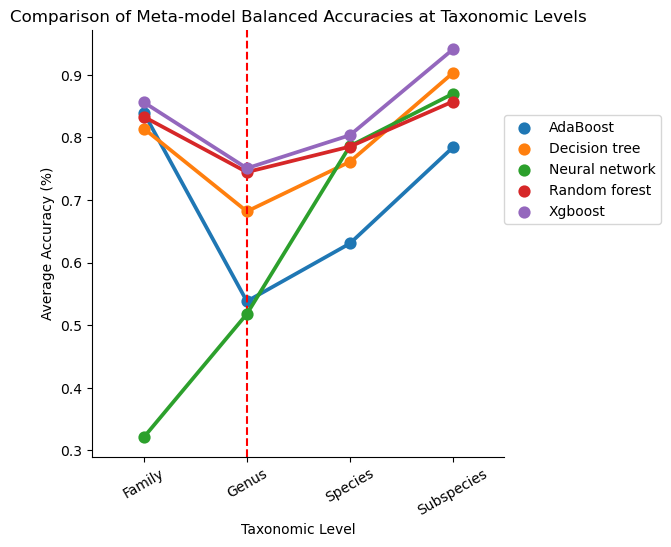

In [82]:
g = sns.catplot(data=avg_accuracy_scores, x='taxon_level', y='accuracy', hue='model_type', kind='point')
g.refline(x=1, color='red')
g._legend.remove()
g.set(xlabel=None)
g.set(ylabel=None)

plt.xticks(rotation=30)
plt.title('Comparison of Meta-model Balanced Accuracies at Taxonomic Levels')
plt.xlabel('Taxonomic Level')
plt.ylabel('Average Accuracy (%)')
plt.legend(bbox_to_anchor=(1.0, 0.8), loc='upper left', borderaxespad=0)
plt.show()

In [83]:
avg_f1_scores = report_collection_df.groupby(['taxon_level', 'model_type']).agg({'f1-score': 'mean'})

In [84]:
avg_f1_scores.head()

f1-score
taxon_level model_type              
Family      AdaBoost        0.735444
            Decision tree   0.750706
            Neural network  0.124459
            Random forest   0.778145
            Xgboost         0.800558

In [85]:
avg_f1_scores = avg_f1_scores.reset_index()

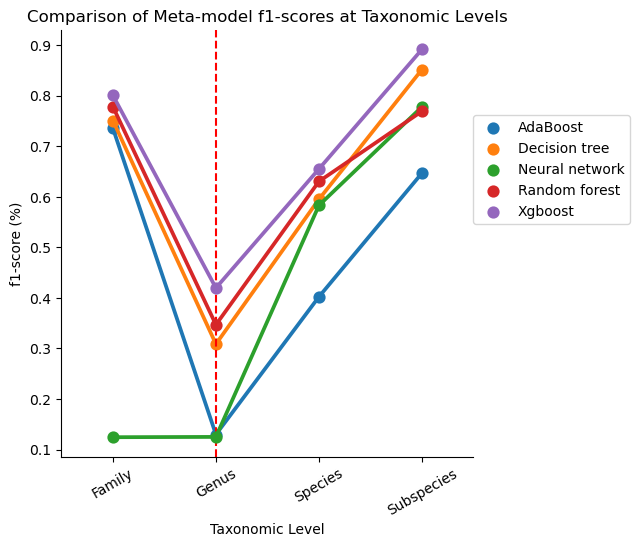

In [86]:
g = sns.catplot(data=avg_f1_scores, x='taxon_level', y='f1-score', hue='model_type', kind='point')
g.refline(x=1, color='red')
g._legend.remove()
g.set(xlabel=None)
g.set(ylabel=None)

plt.xticks(rotation=30)
plt.title('Comparison of Meta-model f1-scores at Taxonomic Levels')
plt.xlabel('Taxonomic Level')
plt.ylabel('f1-score (%)')
plt.legend(bbox_to_anchor=(1.0, 0.8), loc='upper left', borderaxespad=0)
plt.show()

## Family Level Analysis

In [87]:
family_df = report_collection_df[report_collection_df['taxon_level'] == 'Family'].copy()

In [88]:
avg_family_scores = family_df.groupby(['model_type']).agg({'precision':'mean',
                                                        'recall': 'mean',
                                                       'f1-score': 'mean'})

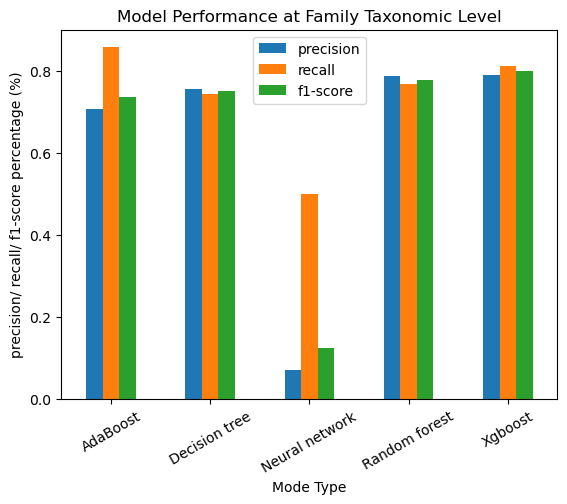

In [89]:
avg_family_scores.plot(kind='bar')

plt.xticks(rotation=30)
plt.ylabel('precision/ recall/ f1-score percentage (%)')
plt.xlabel('Mode Type')
plt.legend()
plt.title('Model Performance at Family Taxonomic Level')
plt.show()

In [27]:
family_df = family_df.rename_axis('taxonomic_name').reset_index()

In [28]:
df_orig_family = df.copy()
df_orig_family = df_orig_family.dropna(subset=['taxon_family_name'])

In [29]:
order = family_df['taxonomic_name'].unique().tolist()

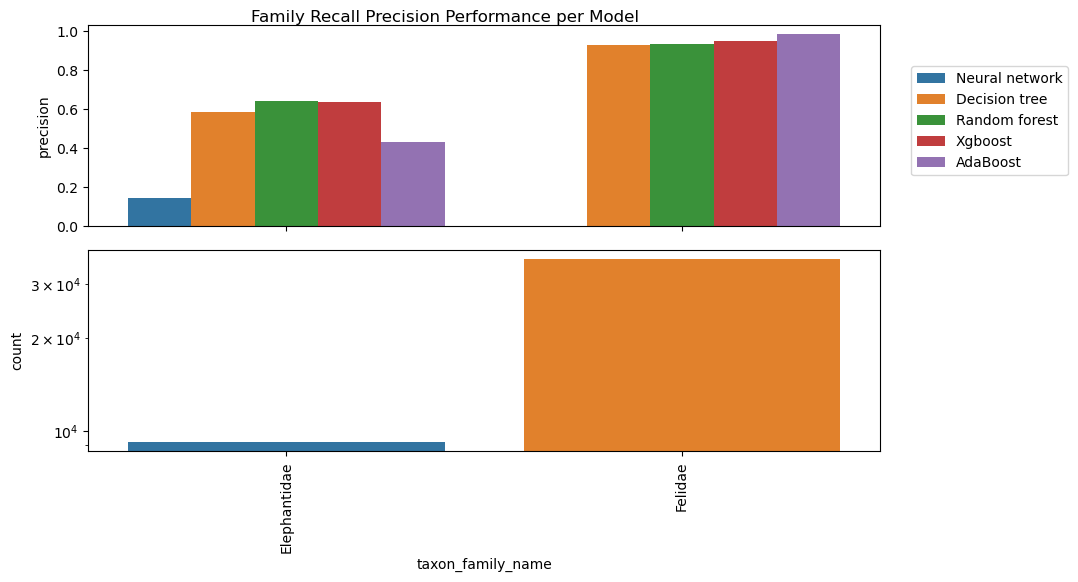

In [30]:
f, axs = plt.subplots(2,1,
                      figsize=(9,5),
                      sharex=True)

h = sns.barplot(data=family_df, x='taxonomic_name', y='precision', hue='model_type', ax=axs[0], order=order)
h.legend_.remove()
h.set(xlabel=None)

g = sns.countplot(x='taxon_family_name', data=df_orig_family, ax=axs[1], order=order)
g.set_yscale('log')

f.tight_layout()
f.legend(bbox_to_anchor=(1.2, 0.9))

plt.xticks(rotation=90)
f.suptitle('Family Recall Precision Performance per Model', y=1)

plt.show()

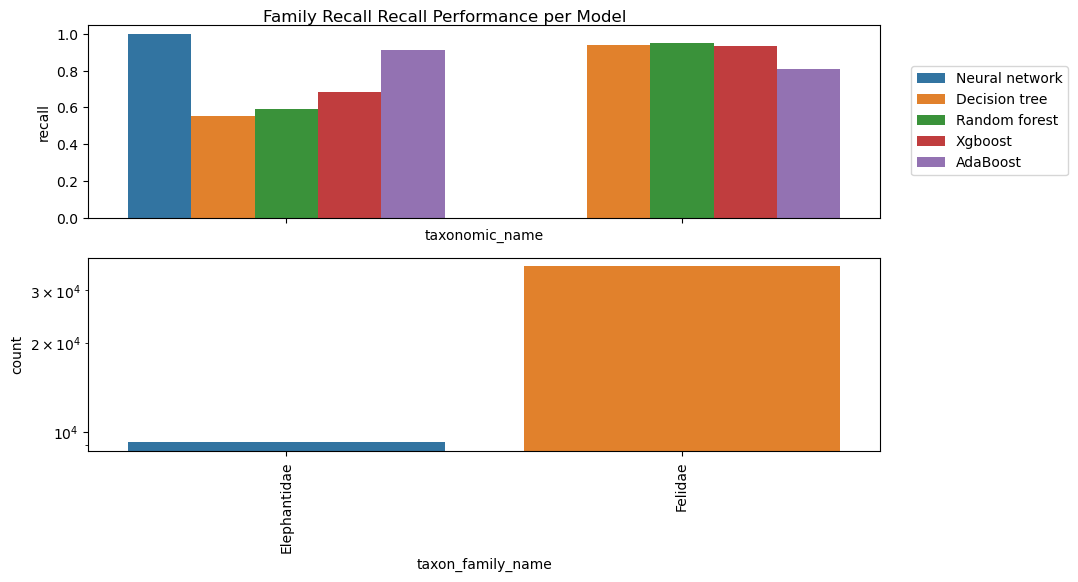

In [31]:
f, axs = plt.subplots(2,1,
                      figsize=(9,5),
                      sharex=True)

h = sns.barplot(data=family_df, x='taxonomic_name', y='recall', hue='model_type', ax=axs[0], order=order)
h.legend_.remove()

g = sns.countplot(x='taxon_family_name', data=df_orig_family, ax=axs[1], order=order)
g.set_yscale('log')

f.tight_layout()
f.legend(bbox_to_anchor=(1.2, 0.9))

plt.xticks(rotation=90)
f.suptitle('Family Recall Recall Performance per Model', y=1)
plt.show()

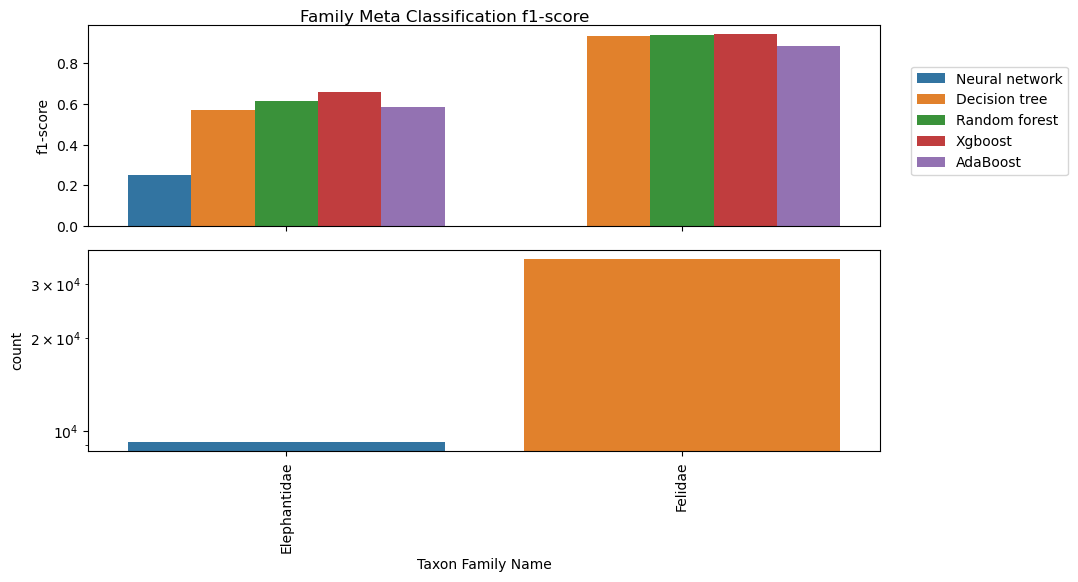

In [32]:
f, axs = plt.subplots(2,1,
                      figsize=(9,5),
                      sharex=True)

h = sns.barplot(data=family_df, x='taxonomic_name', y='f1-score', hue='model_type', ax=axs[0], order=order)
h.legend_.remove()
h.set(xlabel=None)

g = sns.countplot(x='taxon_family_name', data=df_orig_family, ax=axs[1], order=order)
g.set_yscale('log')

f.tight_layout()
f.legend(bbox_to_anchor=(1.2, 0.9))

plt.xticks(rotation=90)
f.suptitle('Family Meta Classification f1-score', y=1)
plt.xlabel('Taxon Family Name')
plt.show()

## Genus Level Analysis

In [90]:
genus_df = report_collection_df[report_collection_df['taxon_level'] == 'Genus'].copy()

#### Average Model Scores at Taxon genus

In [91]:
avg_genus_scores = genus_df.groupby(['model_type']).agg({'precision':'mean',
                                                        'recall': 'mean',
                                                       'f1-score': 'mean'})

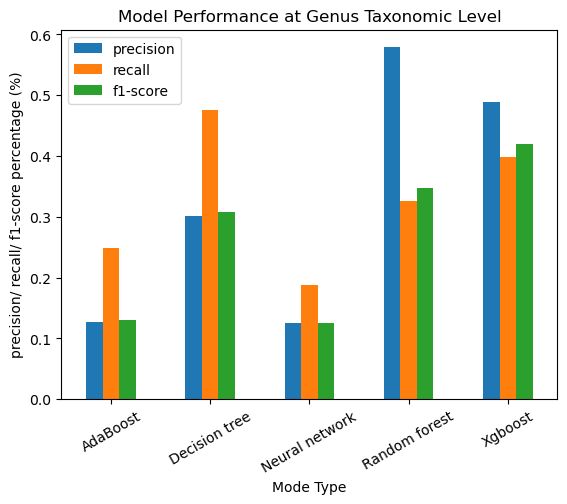

In [92]:
avg_genus_scores.plot(kind='bar')

plt.xticks(rotation=30)
plt.ylabel('precision/ recall/ f1-score percentage (%)')
plt.xlabel('Mode Type')
plt.legend()
plt.title('Model Performance at Genus Taxonomic Level')
plt.show()

#### Individaul Genus Level Analysis

In [93]:
genus_df = genus_df.rename_axis('taxonomic_name').reset_index()

In [94]:
genus_df.head()

,taxonomic_name,precision,recall,f1-score,support,taxon_level,model_type
0,Elephas,1.0,1.0,1.0,317.0,Genus,Neural network
1,Loxodonta,1.0,1.0,1.0,1522.0,Genus,Neural network
2,Acinonyx,0.0,0.0,0.0,300.0,Genus,Neural network
3,Caracal,0.0,0.0,0.0,89.0,Genus,Neural network
4,Catopuma,0.0,0.0,0.0,1.0,Genus,Neural network


In [95]:
df_orig_genus = df.copy()
df_orig_genus = df_orig_genus.dropna(subset=['taxon_genus_name'])

In [96]:
order = genus_df['taxonomic_name'].unique().tolist()

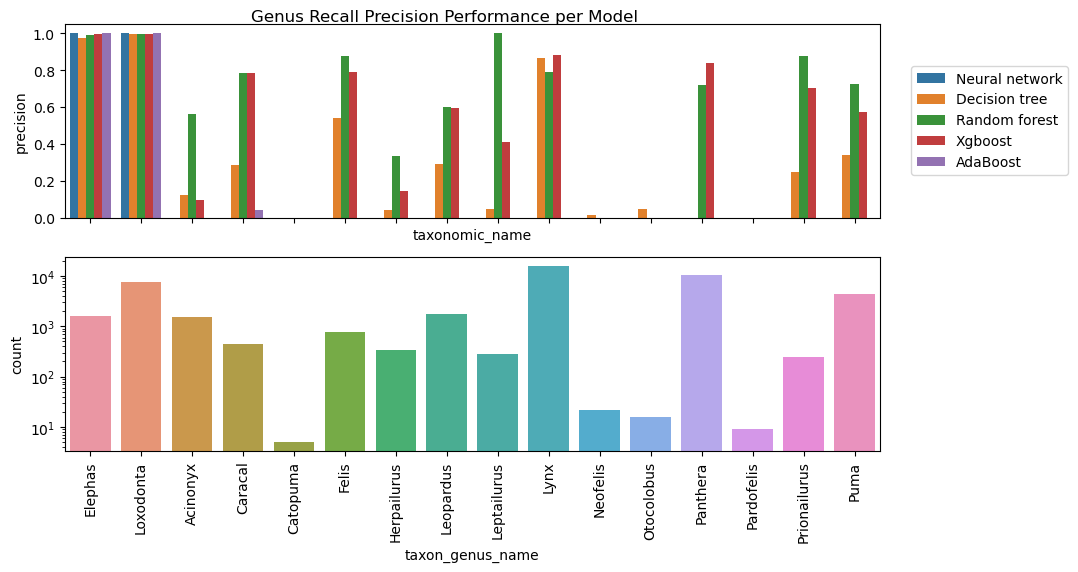

In [97]:
f, axs = plt.subplots(2,1,
                      figsize=(9,5),
                      sharex=True)

h = sns.barplot(data=genus_df, x='taxonomic_name', y='precision', hue='model_type', ax=axs[0], order=order)
h.legend_.remove()

g = sns.countplot(x='taxon_genus_name', data=df_orig_genus, ax=axs[1], order=order)
g.set_yscale('log')

f.tight_layout()
f.legend(bbox_to_anchor=(1.2, 0.9))

plt.xticks(rotation=90)
f.suptitle('Genus Recall Precision Performance per Model', y=1)
plt.show()

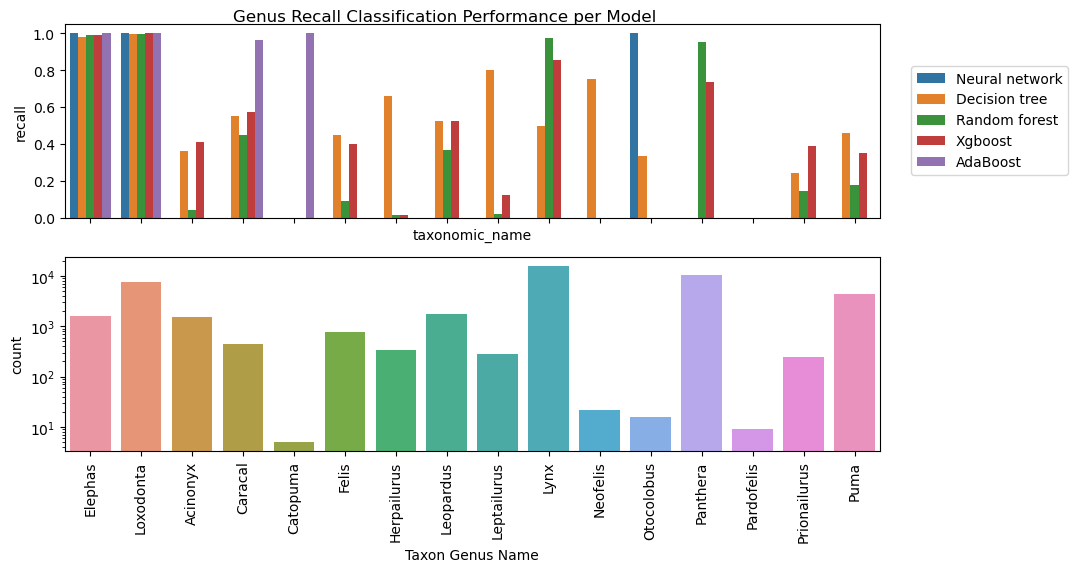

In [98]:
f, axs = plt.subplots(2,1,
                      figsize=(9,5),
                      sharex=True)

h = sns.barplot(data=genus_df, x='taxonomic_name', y='recall', hue='model_type', ax=axs[0], order=order)
h.legend_.remove()

g = sns.countplot(x='taxon_genus_name', data=df_orig_genus, ax=axs[1], order=order)
g.set_yscale('log')

f.tight_layout()
f.legend(bbox_to_anchor=(1.2, 0.9))

plt.xticks(rotation=90)
f.suptitle('Genus Recall Classification Performance per Model', y=1)
plt.xlabel('Taxon Genus Name')
plt.show()

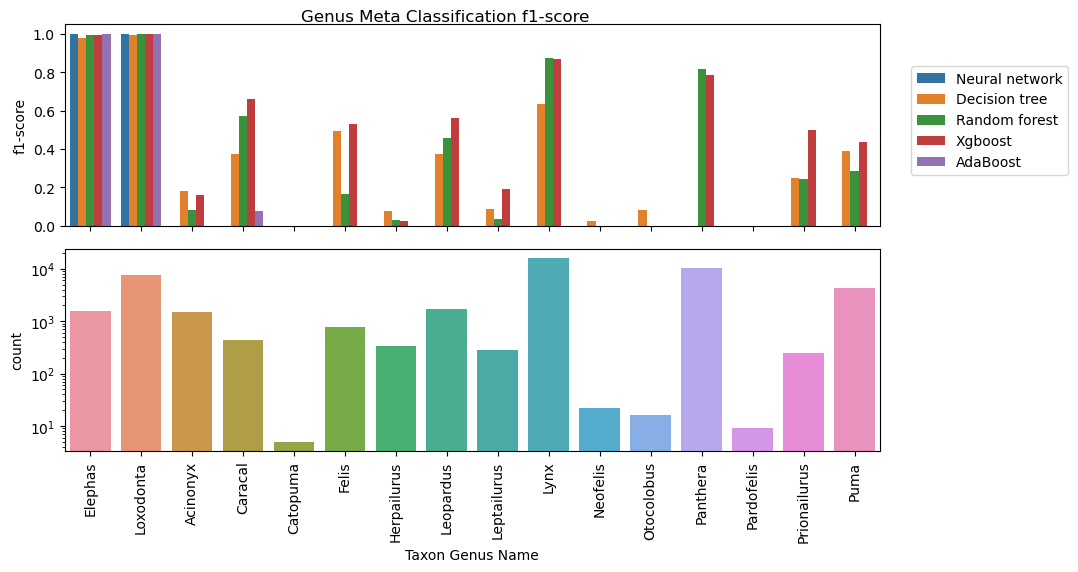

In [99]:
f, axs = plt.subplots(2,1,
                      figsize=(9,5),
                      sharex=True)

h = sns.barplot(data=genus_df, x='taxonomic_name', y='f1-score', hue='model_type', ax=axs[0], order=order)
h.legend_.remove()
h.set(xlabel=None)

g = sns.countplot(x='taxon_genus_name', data=df_orig_genus, ax=axs[1], order=order)
g.set_yscale('log')

f.tight_layout()
f.legend(bbox_to_anchor=(1.2, 0.9))

plt.xticks(rotation=90)
f.suptitle('Genus Meta Classification f1-score', y=1)
plt.xlabel('Taxon Genus Name')
plt.show()

**Analysis**

Meta-data models at the Genus taxonomic level has varied performance. For relatively simple and well-behaved Genus types such as Elephas and Loxondonta, the models performs exceedingly well, however for more imbalanced complicated genus types such as Leopardus the models perform extremely poorly often over-training, and predicting only a single class.

## Species Level Analysis

In [43]:
species_df = report_collection_df[report_collection_df['taxon_level'] == 'Species'].copy()

In [44]:
avg_species_scores = species_df.groupby(['model_type']).agg({'precision':'mean',
                                                        'recall': 'mean',
                                                       'f1-score': 'mean'})

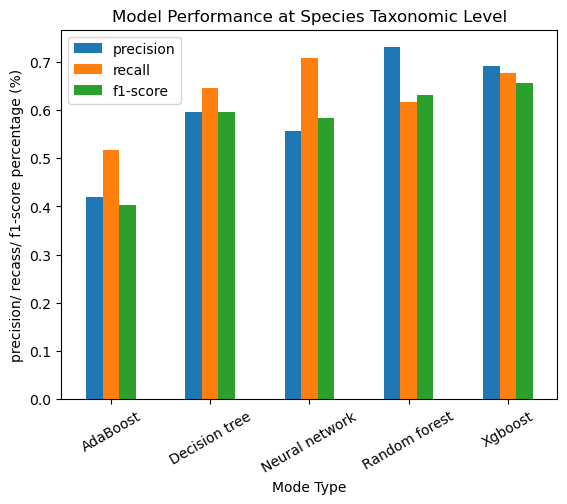

In [45]:
avg_species_scores.plot(kind='bar')

plt.xticks(rotation=30)
plt.ylabel('precision/ recass/ f1-score percentage (%)')
plt.xlabel('Mode Type')
plt.legend()
plt.title('Model Performance at Species Taxonomic Level')
plt.show()

#### Individual Species Level Analysis

In [46]:
species_df = species_df.rename_axis('taxonomic_name').reset_index()

In [47]:
df_orig_species = df.copy()
df_orig_species = df_orig_species.dropna(subset=['taxon_species_name'])

In [48]:
order = species_df['taxonomic_name'].unique().tolist()

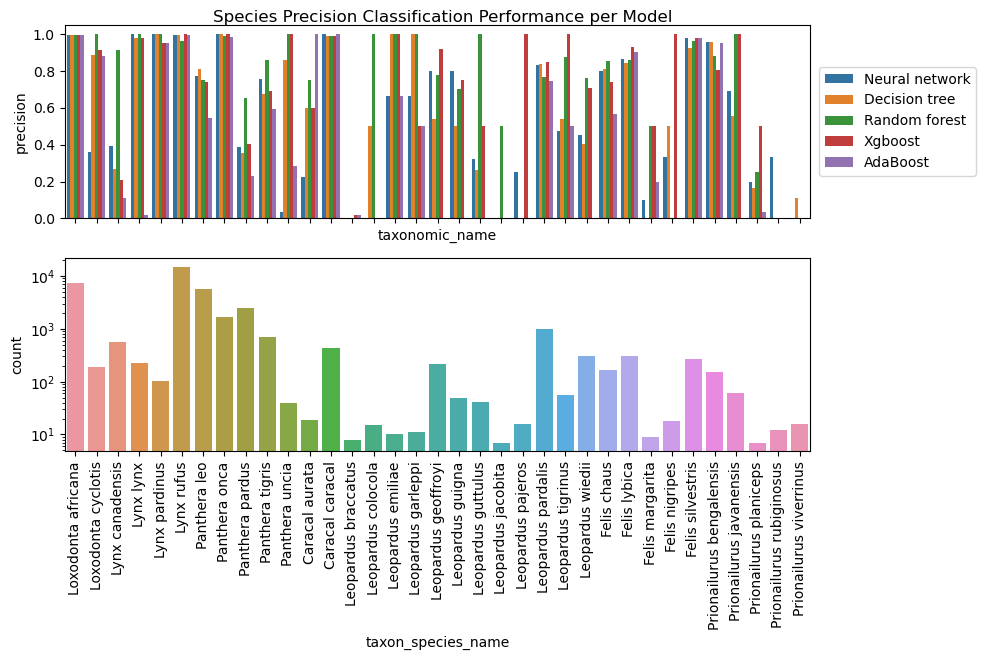

In [49]:
f, axs = plt.subplots(2,1,
                      figsize=(9,5),
                      sharex=True)

h = sns.barplot(data=species_df, x='taxonomic_name', y='precision', hue='model_type', ax=axs[0], order=order)
h.legend_.remove()

g = sns.countplot(x='taxon_species_name', data=df_orig_species, ax=axs[1], order=order)
g.set_yscale('log')

f.tight_layout()
f.legend(bbox_to_anchor=(1.1, 0.9))

plt.xticks(rotation=90)
f.suptitle('Species Precision Classification Performance per Model', y=1)
plt.show()

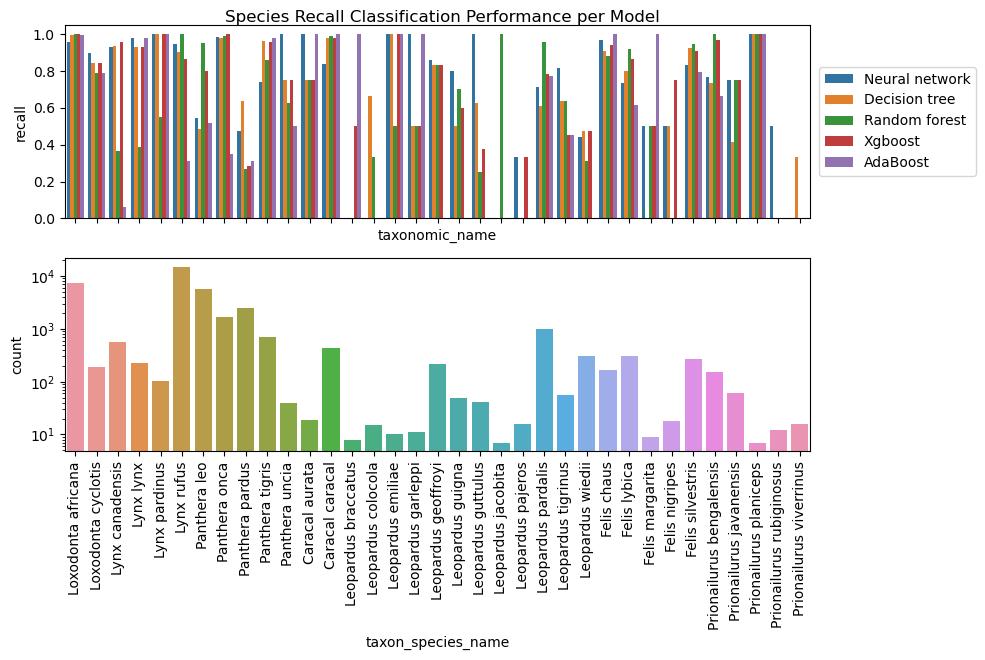

In [50]:
f, axs = plt.subplots(2,1,
                      figsize=(9,5),
                      sharex=True)

h = sns.barplot(data=species_df, x='taxonomic_name', y='recall', hue='model_type', ax=axs[0], order=order)
h.legend_.remove()

g = sns.countplot(x='taxon_species_name', data=df_orig_species, ax=axs[1], order=order)
g.set_yscale('log')

f.tight_layout()
f.legend(bbox_to_anchor=(1.1, 0.9))

plt.xticks(rotation=90)
f.suptitle('Species Recall Classification Performance per Model', y=1)
plt.show()

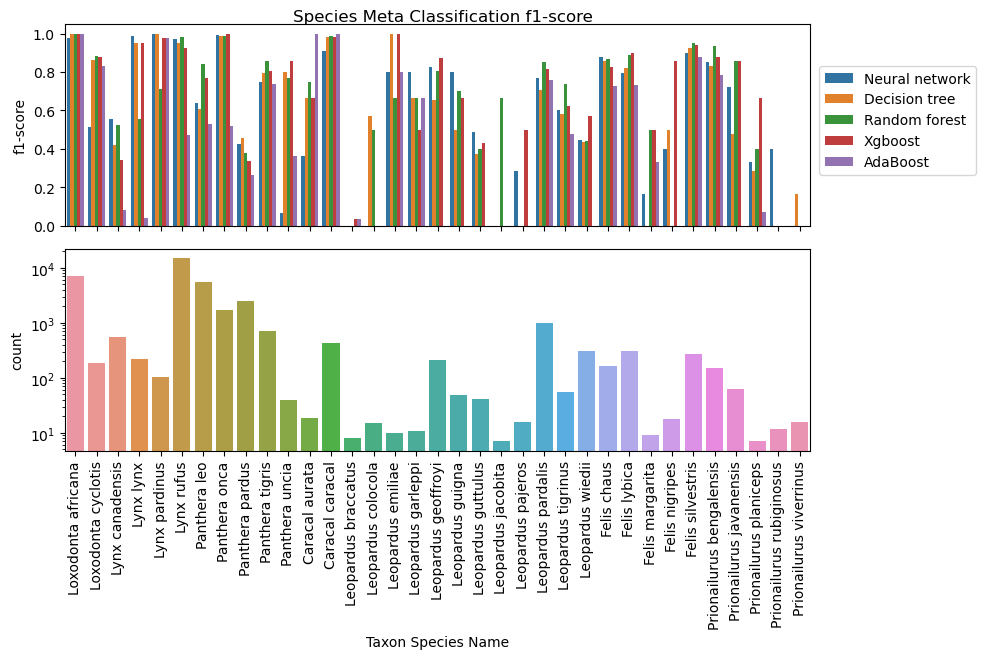

In [51]:
f, axs = plt.subplots(2,1,
                      figsize=(9,5),
                      sharex=True)

h = sns.barplot(data=species_df, x='taxonomic_name', y='f1-score', hue='model_type', ax=axs[0], order=order)
h.legend_.remove()
h.set(xlabel=None)

g = sns.countplot(x='taxon_species_name', data=df_orig_species, ax=axs[1], order=order)
g.set_yscale('log')

f.tight_layout()
f.legend(bbox_to_anchor=(1.1, 0.9))

plt.xticks(rotation=90)
f.suptitle('Species Meta Classification f1-score', y=1)
plt.xlabel('Taxon Species Name')
plt.show()

## Subspecies

In [52]:
subspecies_df = report_collection_df[report_collection_df['taxon_level'] == 'Subspecies'].copy()

In [53]:
avg_subspecies_scores = subspecies_df.groupby(['model_type']).agg({'precision':'mean',
                                                        'recall': 'mean',
                                                       'f1-score': 'mean'})

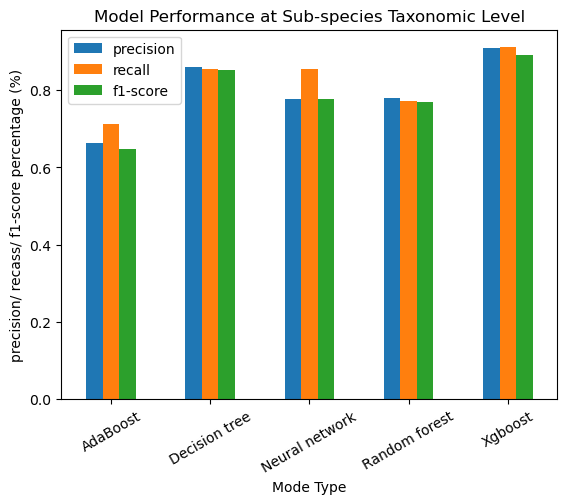

In [55]:
avg_subspecies_scores.plot(kind='bar')
plt.xticks(rotation=30)

plt.ylabel('precision/ recass/ f1-score percentage (%)')
plt.xlabel('Mode Type')
plt.legend()
plt.title('Model Performance at Sub-species Taxonomic Level')
plt.show()

In [56]:
sub_species_df = subspecies_df.rename_axis('taxonomic_name').reset_index()

In [57]:
df_orig_subspecies = df.copy()
df_orig_subspecies = df_orig_subspecies.dropna(subset=['sub_species'])

In [58]:
order = sub_species_df['taxonomic_name'].unique().tolist()

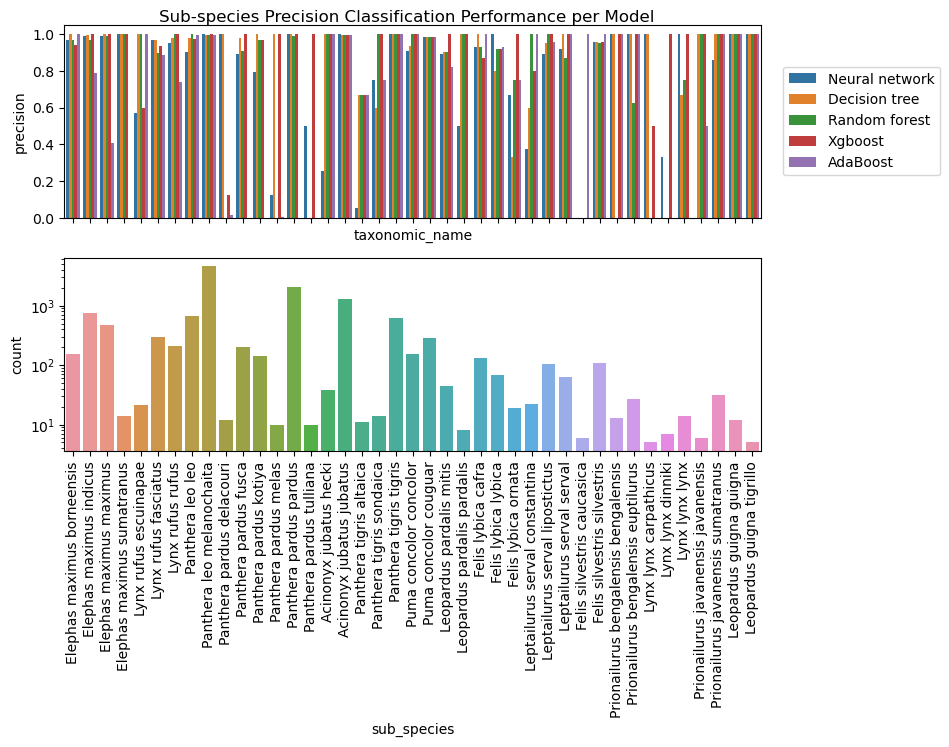

In [59]:
f, axs = plt.subplots(2,1,
                      figsize=(9,5),
                      sharex=True)

h = sns.barplot(data=sub_species_df, x='taxonomic_name', y='precision', hue='model_type', ax=axs[0], order=order)
h.legend_.remove()

g = sns.countplot(x='sub_species', data=df_orig_subspecies, ax=axs[1], order=order)
g.set_yscale('log')

f.tight_layout()
f.legend(bbox_to_anchor=(1.1, 0.9))

plt.xticks(rotation=90)
f.suptitle('Sub-species Precision Classification Performance per Model', y=1)
plt.show()

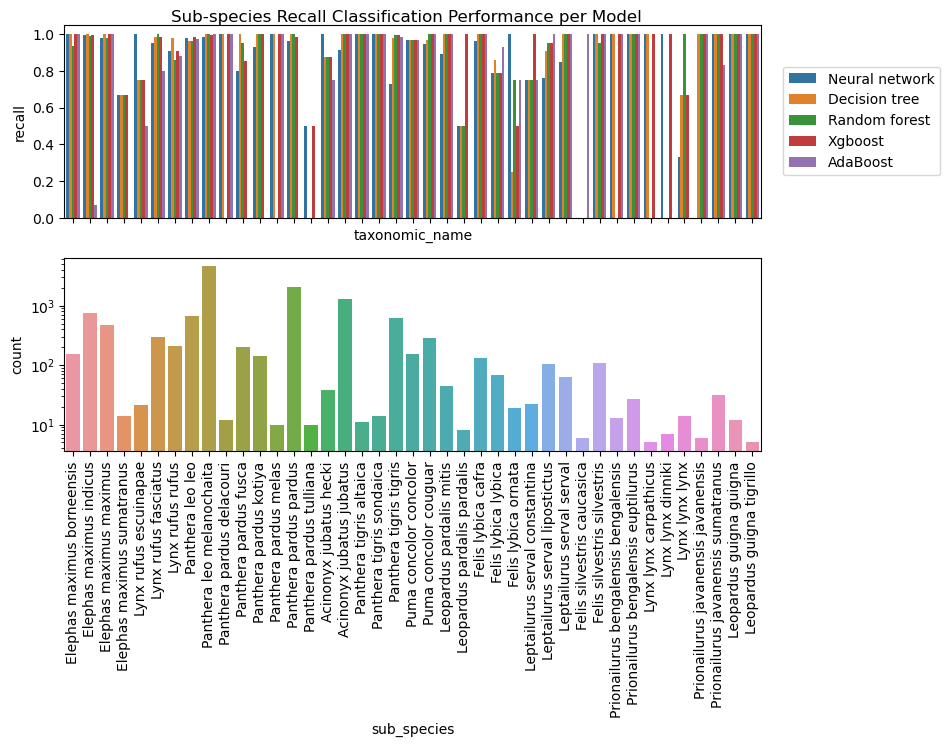

In [61]:
f, axs = plt.subplots(2,1,
                      figsize=(9,5),
                      sharex=True)

h = sns.barplot(data=sub_species_df, x='taxonomic_name', y='recall', hue='model_type', ax=axs[0], order=order)
h.legend_.remove()

g = sns.countplot(x='sub_species', data=df_orig_subspecies, ax=axs[1], order=order)
g.set_yscale('log')

f.tight_layout()
f.legend(bbox_to_anchor=(1.1, 0.9))

plt.xticks(rotation=90)
f.suptitle('Sub-species Recall Classification Performance per Model', y=1)
plt.show()

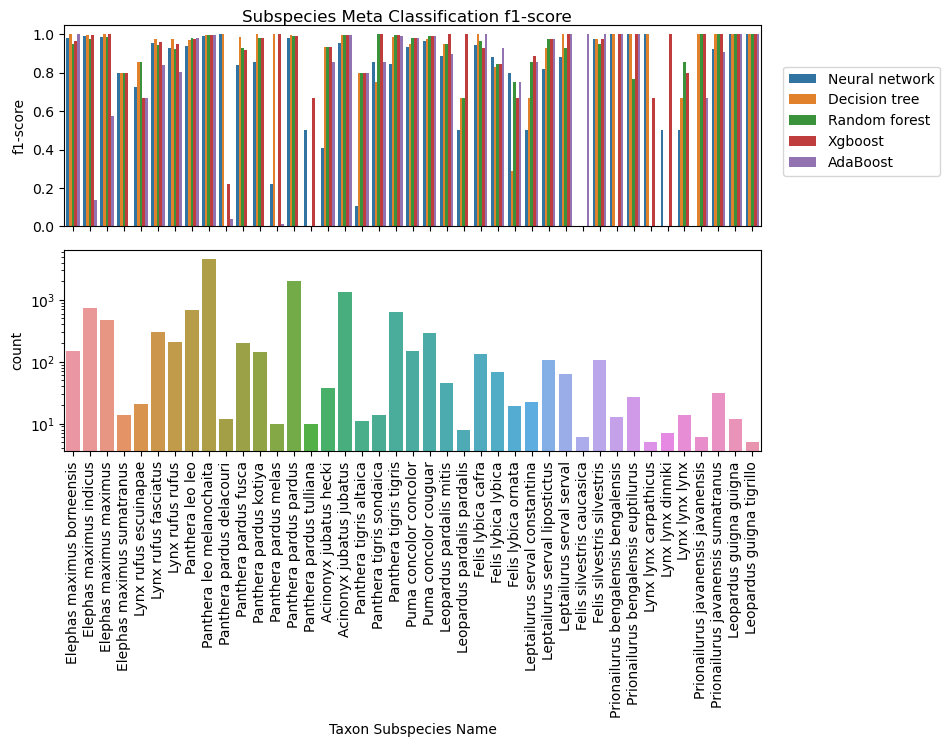

In [62]:
f, axs = plt.subplots(2,1,
                      figsize=(9,5),
                      sharex=True)

h = sns.barplot(data=sub_species_df, x='taxonomic_name', y='f1-score', hue='model_type', ax=axs[0], order=order)
h.legend_.remove()
h.set(xlabel=None)

g = sns.countplot(x='sub_species', data=df_orig_subspecies, ax=axs[1], order=order)
g.set_yscale('log')

f.tight_layout()
f.legend(bbox_to_anchor=(1.1, 0.9))

plt.xticks(rotation=90)
f.suptitle('Subspecies Meta Classification f1-score', y=1)
plt.xlabel('Taxon Subspecies Name')
plt.show()